# 範例重點
學習如何在 keras 中加入自定義的 callbacks <br />
知道 callback function 可以動作的時機 <br />

In [1]:
from keras.layers import Dense, Conv2D, Activation, BatchNormalization, Dropout, Flatten, MaxPooling2D, Input
import keras
import matplotlib.pyplot as plt

!nvidia-smi

Using TensorFlow backend.


Tue Jul 23 22:51:37 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    17W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
(train_x, train_y), (test_x, test_y) = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
def preproc_x(x, flatten = True):
  x = x / 255.0
  if flatten :
    x = x.reshape((len(x), -1))
  return x

def preproc_y(y, num_classes = 10):
  
  if y.shape[-1] == 1:
    y = keras.utils.to_categorical(y, num_classes)
  return y

In [0]:
train_x = preproc_x(train_x)
train_y = preproc_y(train_y)

test_x = preproc_x(test_x)
test_y = preproc_y(test_y)

In [0]:
def build_mlp(input_shape, output_units = 10, num_neurons = [512, 256, 128]):
  
  input_layer = Input(input_shape, name = "main_input")
  
  for i, n_neuron in enumerate(num_neurons):
    if i == 0 :
      x = Dense(units = n_neuron, name = "Hidden_layer_" + str(i+1))(input_layer)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)
    else :
      x = Dense(units = n_neuron, name = "Hidden_layer_" + str(i+1))(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)
      
  output_layer = Dense(units = output_units, activation = 'softmax', name = "main_output") (x)
  
  model = keras.models.Model(inputs = [input_layer], outputs = [output_layer])
  return model  

In [0]:
lr = 1e-3
momentum = 0.95
#Large batch size will overfit easily
batch_size = 1024
epochs = 50

In [0]:
from sklearn.metrics import f1_score

class f1sc(keras.callbacks.Callback):
  
  def on_train_begin(self, epoch, logs = {}):
    logs = logs or {}
    record_item = ["val_auc", "val_f1sc", "val_fp", "val_fn", "val_tp", "val_tn"]
    for item in record_item:
      if item not in self.params['metrics']:
        self.params['metrics'].append(item)
  
  def on_epoch_end(self, epoch, logs = {}, thres = 0.5):
    logs = logs or {}
    y_true = self.validation_data[1].argmax(axis = 1)
    y_pred = self.model.predict(self.validation_data[0])
    y_pred = (y_pred[:,1] >= thres) * 1
    
    logs["val_f1sc"] = f1_score(y_true = y_true, y_pred = y_pred, average = "weighted")
    
    
log_f1sc = f1sc()

In [8]:
model = build_mlp(train_x.shape[1:], 10)
optimizer = keras.optimizers.SGD(lr = lr, momentum = momentum, nesterov = True)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])
model.summary()

history = model.fit(train_x, train_y, epochs = epochs, batch_size = batch_size, shuffle = True, validation_data = [test_x, test_y],
                   callbacks = [log_f1sc])

W0723 22:51:56.868389 140680411588480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 22:51:56.912688 140680411588480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0723 22:51:56.930727 140680411588480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 22:51:57.010012 140680411588480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0723 22:51:57.228057 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
__________

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


50000/50000 [==============================] - 1s 29us/step - loss: 1.7974 - acc: 0.3688 - val_loss: 1.7977 - val_acc: 0.3686
Epoch 3/50
50000/50000 [==============================] - 1s 29us/step - loss: 1.6782 - acc: 0.4128 - val_loss: 1.7133 - val_acc: 0.3945
Epoch 4/50
50000/50000 [==============================] - 1s 28us/step - loss: 1.6068 - acc: 0.4383 - val_loss: 1.6546 - val_acc: 0.4194
Epoch 5/50
50000/50000 [==============================] - 1s 28us/step - loss: 1.5521 - acc: 0.4587 - val_loss: 1.6182 - val_acc: 0.4311
Epoch 6/50
50000/50000 [==============================] - 1s 29us/step - loss: 1.5067 - acc: 0.4735 - val_loss: 1.5882 - val_acc: 0.4421
Epoch 7/50
50000/50000 [==============================] - 1s 28us/step - loss: 1.4676 - acc: 0.4881 - val_loss: 1.5586 - val_acc: 0.4526
Epoch 8/50
50000/50000 [==============================] - 1s 28us/step - loss: 1.4315 - acc: 0.5020 - val_loss: 1.5403 - val_acc: 0.4548
Epoch 9/50
50000/50000 [============================

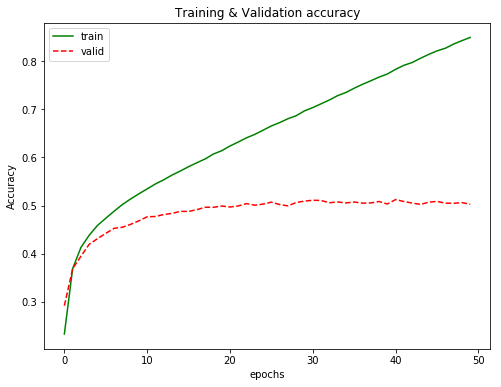

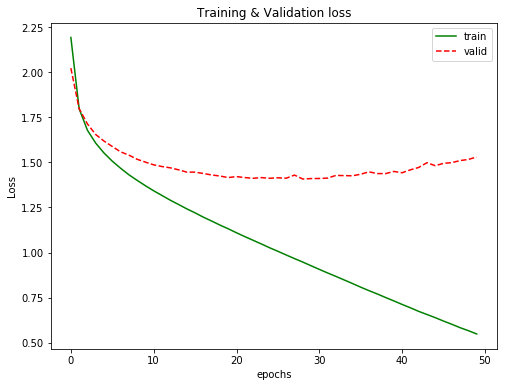

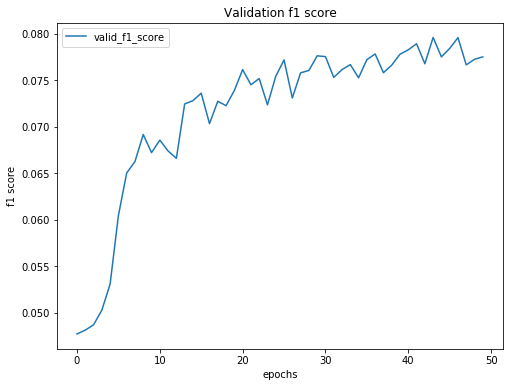

In [9]:
plt.figure(figsize = (8,6))
plt.plot(history.history['acc'],'-', label = "train", color = 'g')
plt.plot(history.history['val_acc'],'--', label = 'valid', color = 'r')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title("Training & Validation accuracy")
plt.legend()
plt.show()

plt.figure(figsize = (8,6))
plt.plot(history.history['loss'],'-', label = "train", color = 'g')
plt.plot(history.history['val_loss'],'--', label = "valid", color = 'r')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title("Training & Validation loss")
plt.legend()
plt.show()

plt.figure(figsize = (8,6))
plt.plot(history.history['val_f1sc'], label = 'valid_f1_score')
plt.xlabel('epochs')
plt.ylabel('f1 score')
plt.title('Validation f1 score')
plt.legend()
plt.show()

# Work
請嘗試寫一個 callback 用來記錄各類別在訓練過程中，對驗證集的 True Positive 與 True Negative

In [0]:
#Since Cifar10 is a multi-class problem, so the there will be unique true positive and true negative for each label.
#In Cifa10, we will have 10 different true positive and true negative.

from sklearn.metrics import confusion_matrix, auc, roc_curve
import numpy as np
class Record_tp_tn(keras.callbacks.Callback):
  
  def on_train_begin(self, epoch, logs = {}):
    logs = logs or {}
    print(f"Initial Metrics : {self.params['metrics']}")
    
    record_item = ["val_acu","val_f1sc", "val_precision", "val_recall", "val_tp", "val_tn", "val_fp", "val_fn"]
    for item in record_item:
      if item not in self.params['metrics']:
        self.params['metrics'].append(item)
        
  def on_epoch_end(self, epoch, logs = None, threshold = 0.5):
    logs = logs or {}
    
    y_true = self.validation_data[1].argmax(axis = 1)
    y_pred = self.model.predict(self.validation_data[0])
    y_pred = np.argmax(y_pred, axis = 1)

    labels = np.arange(0,10,1)
    auc_score = []
    for i in labels:
      single_y_true = ( y_true == i ) * 1.0
      single_y_pred = ( y_pred == i ) * 1.0

      fpr, tpr, thresholds = roc_curve(single_y_true, single_y_pred, pos_label = 1)
      auc_score.append(auc(fpr, tpr))
    
    auc_score = np.asarray(auc_score, dtype = float)
    cm = confusion_matrix(y_true, y_pred, labels = labels)
    
    tp = np.asarray( [ cm[i,i] for i in labels ], dtype = int)
    tp_sum = np.sum(tp, axis = 0)
    tn = np.asarray( [ tp_sum - cm[i,i] for i in labels ], dtype = int)
    fp = np.asarray( [ ( np.sum(cm[:,i]) - cm[i,i] ) for i in labels ], dtype = int )
    fn = np.asarray( [ ( np.sum(cm[i,:]) - cm[i,i] ) for i in labels ], dtype = int )
    
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)

    f1score  = 2*tp / (2*tp + fp + fn)
  
    print(f" tp : {tp}, tn : {tn}")
    
    logs["val_tp"] = tp
    logs["val_tn"] = tn
    logs["val_fp"] = fp
    logs["val_fn"] = fn
    logs["val_precision"] = precision
    logs["val_recall"] = recall
    logs["val_f1sc"] = f1score
    logs["val_auc"] = auc_score
record_tp_tn = Record_tp_tn()

In [78]:
model = build_mlp(train_x.shape[1:])
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ['accuracy'])
model.summary()

history = model.fit(train_x, train_y, epochs = epochs, batch_size = batch_size, shuffle = True, validation_data = [test_x, test_y], callbacks = [record_tp_tn])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
batch_normalization_61 (Batc (None, 512)               2048      
_________________________________________________________________
activation_61 (Activation)   (None, 512)               0         
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 256)               131328    
_________________________________________________________________
batch_normalization_62 (Batc (None, 256)               1024      
_________________________________________________________________
activation_62 (Activation)   (None, 256)               0         
__________

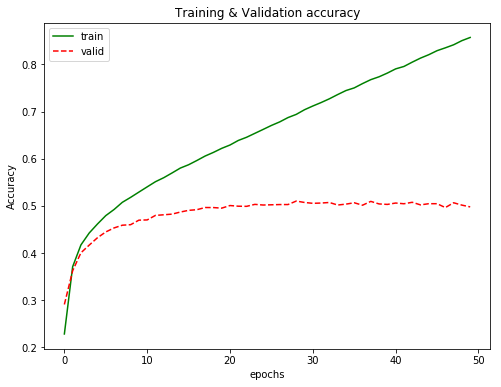

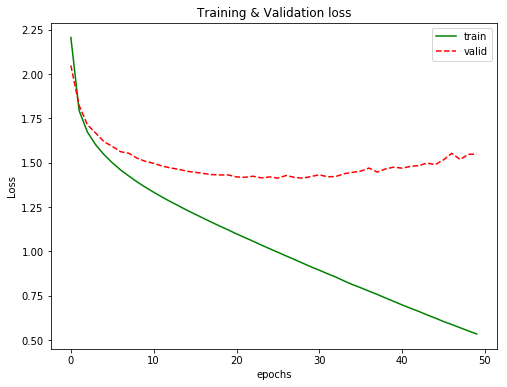

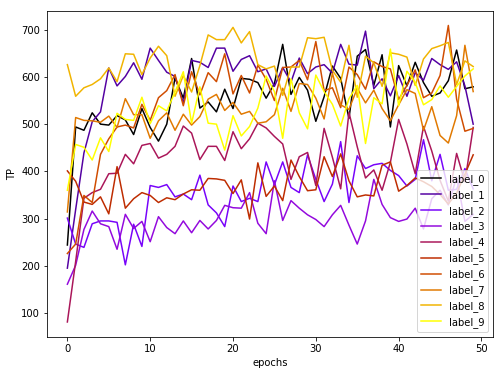

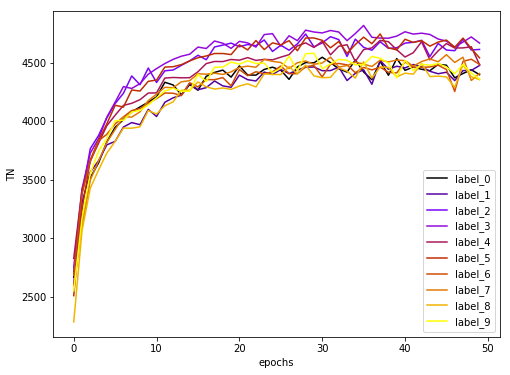

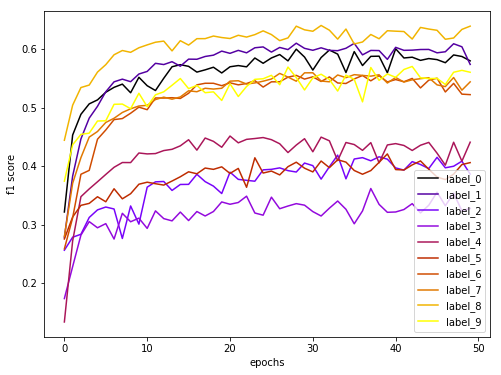

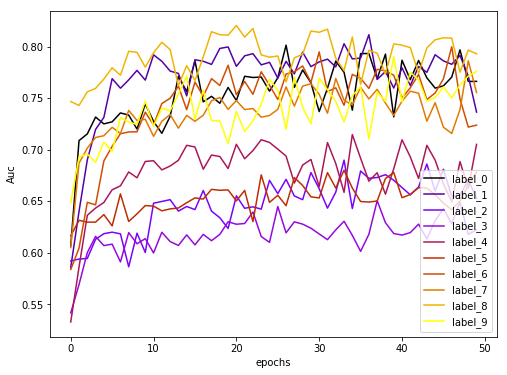

In [79]:
plt.figure(figsize = (8,6))
plt.plot(history.history['acc'],'-', label = "train", color = 'g')
plt.plot(history.history['val_acc'],'--', label = 'valid', color = 'r')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title("Training & Validation accuracy")
plt.legend()
plt.show()

plt.figure(figsize = (8,6))
plt.plot(history.history['loss'],'-', label = "train", color = 'g')
plt.plot(history.history['val_loss'],'--', label = "valid", color = 'r')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title("Training & Validation loss")
plt.legend()
plt.show()


val_tp = np.asarray(history.history['val_tp'], dtype = int)
val_tn = np.asarray(history.history['val_tn'], dtype = int)
val_f1score = np.asarray(history.history['val_f1sc'], dtype = float)
val_auc = np.asarray(history.history['val_auc'], dtype = float)
labels = np.arange(0,10,1)

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0,1,10)]

plt.figure(figsize = (8,6))
for i in labels:
  plt.plot(val_tp[:,i], label = 'label_' + str(i), color = colors[i])
plt.xlabel('epochs')
plt.ylabel('TP')
plt.legend()
plt.show()

plt.figure(figsize = (8,6))
for i in labels:
  plt.plot(val_tn[:,i], label = 'label_' + str(i), color = colors[i])
plt.xlabel('epochs')
plt.ylabel('TN')
plt.legend()
plt.show()


plt.figure(figsize = (8,6))
for i in labels:
  plt.plot(val_f1score[:,i], label = 'label_' + str(i), color = colors[i])
plt.xlabel('epochs')
plt.ylabel('f1 score')
plt.legend()
plt.show()

plt.figure(figsize = (8,6))
for i in labels:
  plt.plot(val_auc[:,i], label = 'label_' + str(i), color = colors[i])
plt.xlabel('epochs')
plt.ylabel('Auc')
plt.legend()
plt.show()